In [1]:
include("../src/Atoms.jl")
include("../src/scfOptions.jl")
include("../src/kerker_mix.jl")
include("../src/Ham.jl")
include("../src/hartree_pot_bc.jl")
include("../src/pseudocharge.jl")
include("../src/getocc.jl")
include("../src/anderson_mix.jl")
using PyPlot

dx = 0.5;
Nunit = 16;
Lat = 10;
Ls = Nunit*Lat;
Ns = round(Integer, Ls / dx); # number of discretization points

# using the default values in Lin's code
betamix = 0.5;
mixdim = 10;
YukawaK = 0.0100;
n_extra = 10;
epsil0 = 10.0;
T_elec = 300.0; #Temperature 4000K

kb = 3.1668e-6;
au2K = 315774.67;
Tbeta = au2K / T_elec;

Ndist  = 1;   # Temporary variable
Natoms = round(Integer, Nunit / Ndist); # number of atoms

R = zeros(Natoms, 1);
for j = 1:Natoms
  R[j] = (j-0.5)*Lat*Ndist+dx;
end

#R[1] = R[1]+1.0;

sigma  = ones(Natoms,1)*(6.0);  # Metal
omega  = ones(Natoms,1)*0.03;
Eqdist = ones(Natoms,1)*10.0;
mass   = ones(Natoms,1)*42000.0;
nocc   = ones(Natoms,1)*2;          # number of electrons per atom
Z      = nocc;

# creating an atom structure
atoms = Atoms(Natoms, R, sigma,  omega,  Eqdist, mass, Z, nocc);

# allocating a Hamiltonian
ham = Ham(Lat, Nunit, n_extra, dx, atoms,YukawaK, epsil0, Tbeta)

# total number of occupied orbitals
Nocc = round(Integer, sum(atoms.nocc) / ham.nspin);

# initialize the potentials within the Hemiltonian, setting H[\rho_0]
init_pot!(ham, Nocc)

rhoa_old = ham.rhoa

# initializing the options
# setting the options for the scf iteration
KerkerB = 0.5;
mixOpts = kerkerMixOptions(betamix, KerkerB, 2*ham.kmul, YukawaK, epsil0)
eigOpts = eigOptions(1.e-10, 1000, "eig");
scfOpts = scfOptions(1.e-8, 1000, eigOpts, mixOpts)

# running the scf iteration
@time VtoterrHist = scf!(ham, scfOpts)

  8.074443 seconds (12.79 M allocations: 1010.792 MiB, 5.93% gc time)


27-element Array{Float64,1}:
 Inf                    
   2.409279121762872    
   0.7646131547172763   
   0.3097687631228411   
   0.13589058635432963  
   0.0615620959884393   
   0.02828460671887356  
   0.01307831359625834  
   0.006064886031702349 
   0.002816308443697711 
   0.0013086087030283408
   0.0006082269977910668
   0.0002827354486753533
   ⋮                    
   2.840776431797944e-5 
   1.3206880616206036e-5
   6.139947073273835e-6 
   2.8544982280152096e-6
   1.3270744445373732e-6
   6.169664659841339e-7 
   2.8683141706491855e-7
   1.3335184110835557e-7
   6.199588678148165e-8 
   2.883515187568604e-8 
   1.3404947593514409e-8
   6.311478376736397e-9 

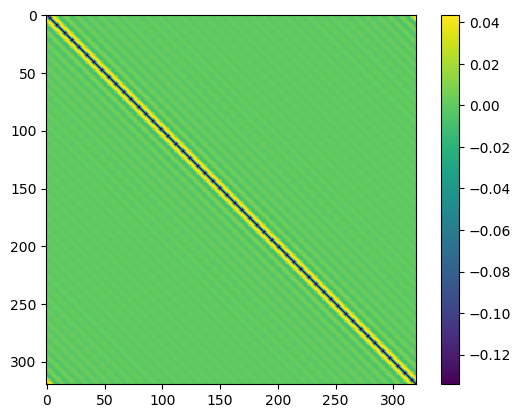

PyObject <matplotlib.colorbar.Colorbar object at 0x129ac42b0>

In [2]:
delta = 0.001
Id = Matrix{Float64}(I,ham.Ns,ham.Ns)
Vc = zeros((ham.Ns,ham.Ns))
for i = 1:ham.Ns
    Vc[:,i] = hartree_pot_bc(reshape(Id[:,i],ham.Ns,1),ham)
end
VcInv = pinv(Vc,1e-10)
chi = zeros(ham.Ns,ham.Ns)
rho_old = ham.rho
rhoa_old = ham.rhoa
VcInv = pinv(Vc,1e-10)
for i = 1:ham.Ns
    Vpert = zeros(ham.Ns,1)
    Vpert[i] = 1    
    ham.rhoa = rhoa_old+delta*(VcInv*Vpert)
    # rhoa_pert = zeros(160,1)
    # rhoa_pert[10] = 1
    # rho_old = ham.rho
    # ham.rhoa = ham.rhoa+delta*rhoa_pert
    scf!(ham, scfOpts)
    rho_new = ham.rho
    RHS = (rho_new-rho_old)/delta
    chi[:,i] = RHS
end
imshow(chi)
colorbar()

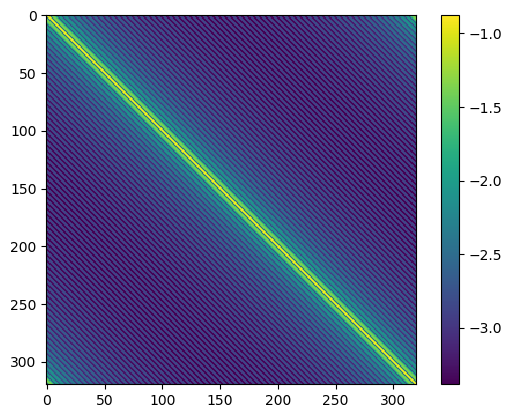

PyObject <matplotlib.colorbar.Colorbar object at 0x12f48ee48>

In [3]:
imshow(log.(abs.(chi))/log(10))
colorbar()

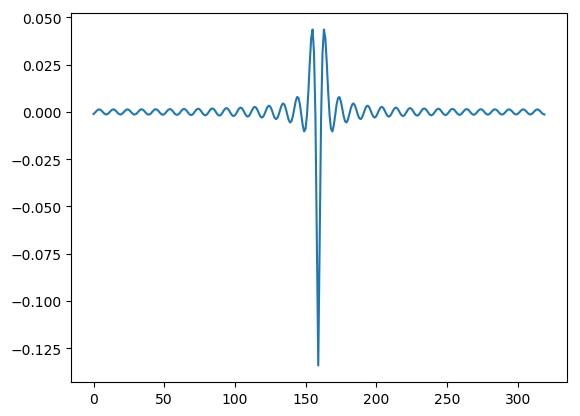

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14069bb00>

In [4]:
plot(chi[:,160]) #plot a random column of chi to see localized behavior

In [5]:
#Everything below is the same as first cell, just to reset the ham object to calculate chi0
dx = 0.5;
Nunit = 16;
Lat = 10;
Ls = Nunit*Lat;
Ns = round(Integer, Ls / dx); # number of discretization points

# using the default values in Lin's code
betamix = 0.5;
mixdim = 10;
YukawaK = 0.0100;
n_extra = 10;
epsil0 = 10.0;
T_elec = 300.0; #Temperature 4000K

kb = 3.1668e-6;
au2K = 315774.67;
Tbeta = au2K / T_elec;

Ndist  = 1;   # Temporary variable
Natoms = round(Integer, Nunit / Ndist); # number of atoms

R = zeros(Natoms, 1);
for j = 1:Natoms
  R[j] = (j-0.5)*Lat*Ndist+dx;
end

#R[1] = R[1]+1.0;

sigma  = ones(Natoms,1)*(6.0);  # Metal
omega  = ones(Natoms,1)*0.03;
Eqdist = ones(Natoms,1)*10.0;
mass   = ones(Natoms,1)*42000.0;
nocc   = ones(Natoms,1)*2;          # number of electrons per atom
Z      = nocc;

# creating an atom structure
atoms = Atoms(Natoms, R, sigma,  omega,  Eqdist, mass, Z, nocc);

# allocating a Hamiltonian
ham = Ham(Lat, Nunit, n_extra, dx, atoms,YukawaK, epsil0, Tbeta)

# total number of occupied orbitals
Nocc = round(Integer, sum(atoms.nocc) / ham.nspin);

# initialize the potentials within the Hemiltonian, setting H[\rho_0]
init_pot!(ham, Nocc)

rhoa_old = ham.rhoa

# initializing the options
# setting the options for the scf iteration
KerkerB = 0.5;
mixOpts = kerkerMixOptions(betamix, KerkerB, 2*ham.kmul, YukawaK, epsil0)
eigOpts = eigOptions(1.e-10, 1000, "eig");
scfOpts = scfOptions(1.e-8, 1000, eigOpts, mixOpts)

# running the scf iteration
@time VtoterrHist = scf!(ham, scfOpts)

  2.970585 seconds (20.26 k allocations: 398.198 MiB, 5.36% gc time)


27-element Array{Float64,1}:
 Inf                    
   2.409279121762872    
   0.7646131547172763   
   0.3097687631228411   
   0.13589058635432963  
   0.0615620959884393   
   0.02828460671887356  
   0.01307831359625834  
   0.006064886031702349 
   0.002816308443697711 
   0.0013086087030283408
   0.0006082269977910668
   0.0002827354486753533
   ⋮                    
   2.840776431797944e-5 
   1.3206880616206036e-5
   6.139947073273835e-6 
   2.8544982280152096e-6
   1.3270744445373732e-6
   6.169664659841339e-7 
   2.8683141706491855e-7
   1.3335184110835557e-7
   6.199588678148165e-8 
   2.883515187568604e-8 
   1.3404947593514409e-8
   6.311478376736397e-9 

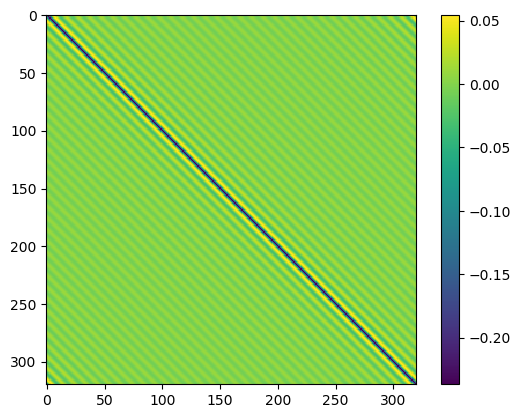

PyObject <matplotlib.colorbar.Colorbar object at 0x1296ebe10>

In [6]:
delta = 0.001
chi0 = zeros(ham.Ns,ham.Ns)
rho_old = ham.rho
Vtot_old = ham.Vtot
for i = 1:ham.Ns
    Vtotpert = zeros(ham.Ns,1)
    Vtotpert[i] = 1
    ham.Vtot = Vtot_old+delta*Vtotpert
    update_psi!(ham, eigOpts)
    Nocc = round(Integer, sum(ham.atoms.nocc) / ham.nspin);
    update_rho!(ham, Nocc)
    rho_new = ham.rho
    RHS = (rho_new-rho_old)/delta
    chi0[:,i] = RHS
end
imshow(chi0)
colorbar()

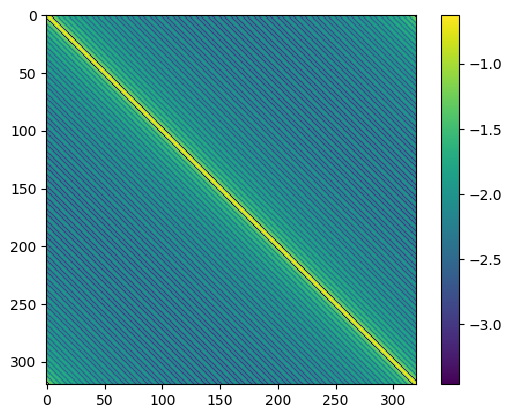

PyObject <matplotlib.colorbar.Colorbar object at 0x1405e99e8>

In [7]:
imshow(log.(abs.(chi0))/log(10))
colorbar()

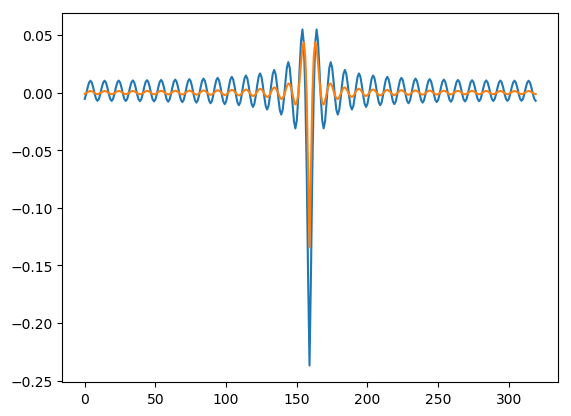

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1440ceb00>

In [8]:
plot(chi0[:,160])
plot(chi[:,160])